<strong>목차</strong>
1. 데이터 전처리
2. CNN기반 베이스 모델 구현
3. 데이터 augmentation을 사용하여 베이스 모델과 성능 비교
4. 모델 구조 변경 후 베이스 모델과 성능 비교
5. ResNet 모델 구현 후 학습

# 1. 데이터 전처리

In [1]:
# 필요한 모듈 불러오기
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action='ignore')

In [2]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

IMAGE_SIZE = 180
SEED = 42

train_normal = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/train/NORMAL/*.jpeg')
train_pneumonia = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/train/PNEUMONIA/*.jpeg')

val_normal = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/val/NORMAL/*.jpeg')
val_pneumonia = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/val/PNEUMONIA/*.jpeg')

test_normal = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/test/NORMAL/*.jpeg')
test_pneumonia = tf.io.gfile.glob(ROOT_PATH + '/chest_xray/data/test/PNEUMONIA/*.jpeg')

BATCH_SIZE = 16
EPOCHS = 10

In [3]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])
train_list.extend([x for x in val_normal])
train_list.extend([x for x in val_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*(len(train_normal)+len(val_normal)) , ['Pneumonia']*(len(train_pneumonia)+len(val_pneumonia))]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

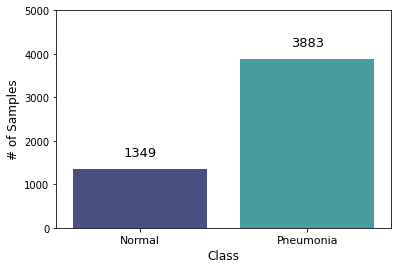

In [4]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

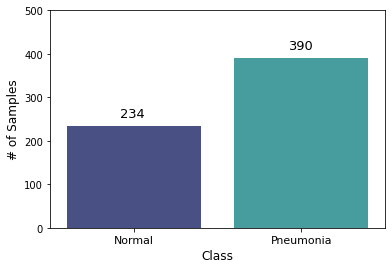

In [5]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

In [6]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [7]:
train_df,val_df

(          class                                              image
 3566  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 2866  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 2681  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 1199     Normal  /aiffel/aiffel/chest_xray/data/train/NORMAL/IM...
 4619  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 ...         ...                                                ...
 3476  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 678      Normal  /aiffel/aiffel/chest_xray/data/train/NORMAL/NO...
 1560  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 2769  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 4881  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 
 [4185 rows x 2 columns],
           class                                              image
 2945  Pneumonia  /aiffel/aiffel/chest_xray/data/train/PNEUMONIA...
 4878  Pneumonia  /a

# 2. 기본 CNN 베이스 모델 구현

In [8]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=output)
    
    return model

In [9]:
model = get_model()
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), 
              metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 178, 178, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 87, 87, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 32)        0     

# 3. Data augmentation 이용하기

In [10]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH_SIZE,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                         x_col = 'image',
                                         y_col = 'class',
                                         target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                         class_mode = 'binary',
                                         batch_size = BATCH_SIZE,
                                         seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                          x_col = 'image',
                                          y_col = 'class',
                                          target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                          class_mode = 'binary',
                                          batch_size = 1,
                                          shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [11]:
history = model.fit(
    ds_train,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=ds_val,
    validation_steps=len(val_df) // BATCH_SIZE,
    )

Epoch 1/10
261/261 [==============================] - 124s 312ms/step - loss: 0.5454 - binary_accuracy: 0.7445 - val_loss: 0.5527 - val_binary_accuracy: 0.8327
Epoch 2/10
261/261 [==============================] - 76s 292ms/step - loss: 0.3813 - binary_accuracy: 0.8345 - val_loss: 0.2620 - val_binary_accuracy: 0.9115
Epoch 3/10
261/261 [==============================] - 76s 293ms/step - loss: 0.2829 - binary_accuracy: 0.8798 - val_loss: 0.3121 - val_binary_accuracy: 0.8702
Epoch 4/10
261/261 [==============================] - 76s 292ms/step - loss: 0.2363 - binary_accuracy: 0.9045 - val_loss: 0.2151 - val_binary_accuracy: 0.9154
Epoch 5/10
261/261 [==============================] - 76s 290ms/step - loss: 0.2138 - binary_accuracy: 0.9211 - val_loss: 0.1711 - val_binary_accuracy: 0.9385
Epoch 6/10
261/261 [==============================] - 76s 292ms/step - loss: 0.2014 - binary_accuracy: 0.9225 - val_loss: 0.1940 - val_binary_accuracy: 0.9250
Epoch 7/10
261/261 [=========================

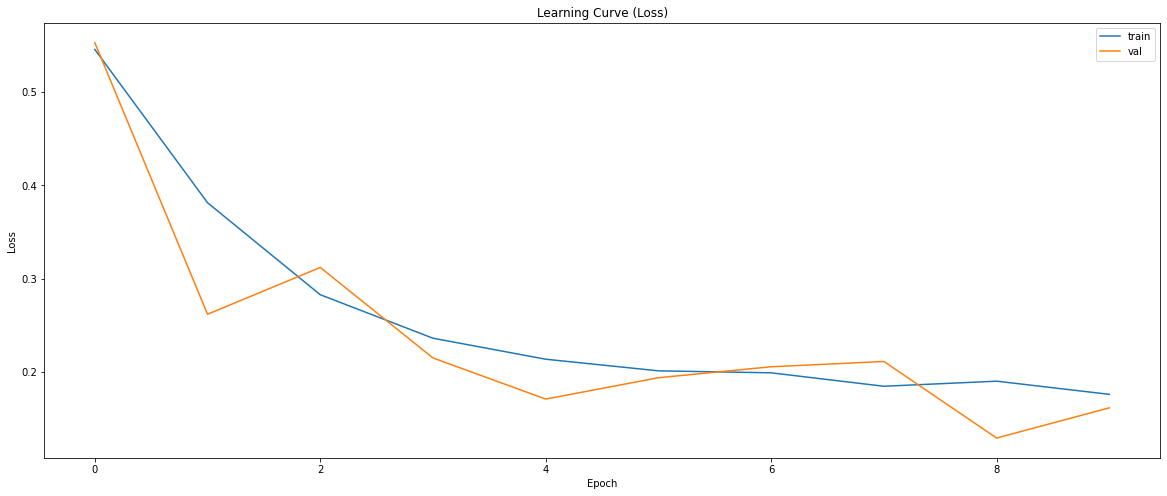

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.show()

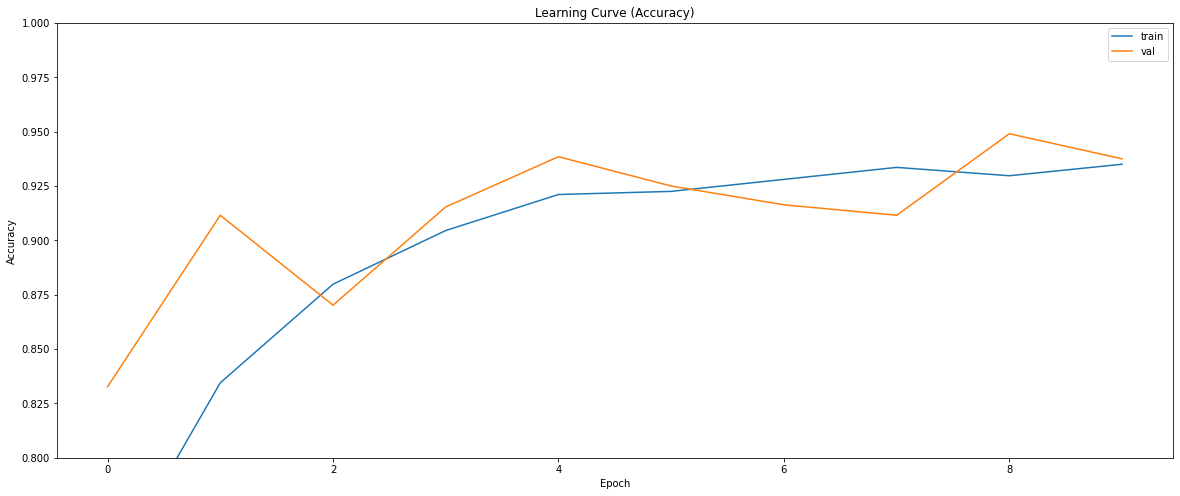

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [14]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH_SIZE, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.16092343628406525
Val accuracy: 0.9379178881645203


# 4. 모델구조 변경하기

In [15]:
# 드롭 아웃 추가, 배치노멀라이제이션 추가
def get_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding='valid')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=[inputs], outputs=output)
    
    return model

In [18]:
# 얼리스탑핑 콜백, 
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)
# ReduceLROnPlateau 콜백 추가
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
)

In [21]:
tf.keras.backend.clear_session()

model = get_model()
model.compile(loss='binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), 
              metrics='binary_accuracy')

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 178, 178, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 32)        4640  

In [22]:
history = model.fit(
    ds_train,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[early_stopping, plateau],
    validation_steps=len(val_df) // BATCH_SIZE,
    )

Epoch 1/10
261/261 [==============================] - 77s 293ms/step - loss: 0.5642 - binary_accuracy: 0.7520 - val_loss: 0.7512 - val_binary_accuracy: 0.7433
Epoch 2/10
261/261 [==============================] - 76s 293ms/step - loss: 0.3595 - binary_accuracy: 0.8359 - val_loss: 0.7876 - val_binary_accuracy: 0.7413
Epoch 3/10
261/261 [==============================] - 76s 291ms/step - loss: 0.3065 - binary_accuracy: 0.8686 - val_loss: 0.2028 - val_binary_accuracy: 0.9298
Epoch 4/10
261/261 [==============================] - 76s 292ms/step - loss: 0.2627 - binary_accuracy: 0.8930 - val_loss: 0.1839 - val_binary_accuracy: 0.9221
Epoch 5/10
261/261 [==============================] - 76s 292ms/step - loss: 0.2369 - binary_accuracy: 0.9077 - val_loss: 0.1749 - val_binary_accuracy: 0.9240
Epoch 6/10
261/261 [==============================] - 76s 292ms/step - loss: 0.2261 - binary_accuracy: 0.9127 - val_loss: 0.1798 - val_binary_accuracy: 0.9202
Epoch 7/10
261/261 [==========================

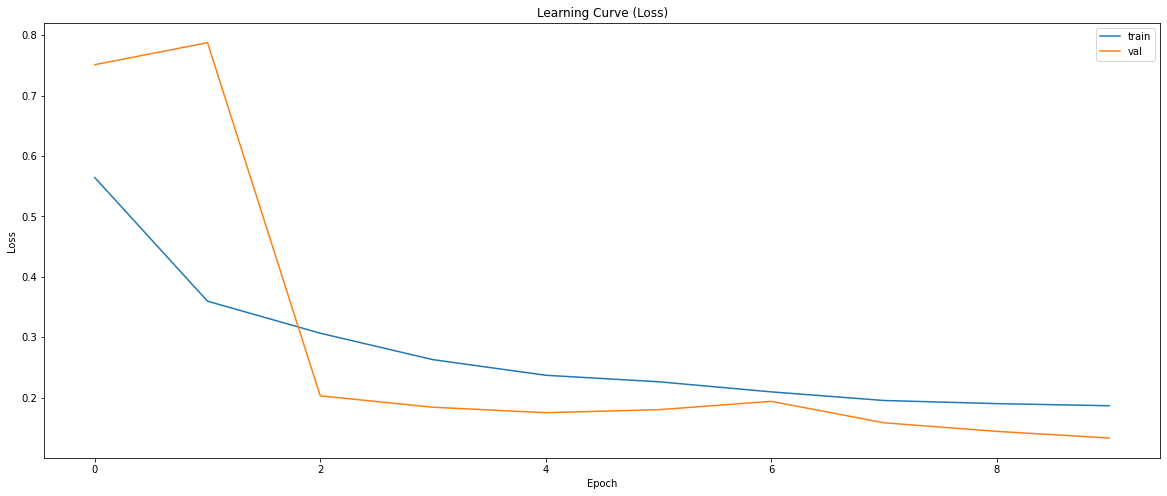

In [23]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.show()

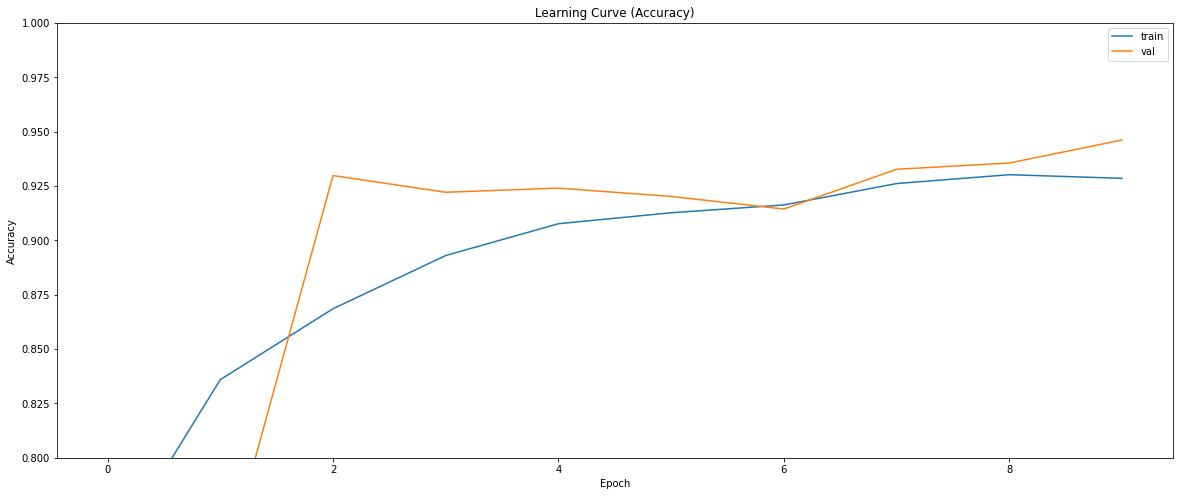

In [24]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [25]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH_SIZE, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.13327740132808685
Val accuracy: 0.9455587267875671


# 5. ResNet 모델 구현 후 학습

In [26]:
# residual block 구조 생성
def residual_block(inputs, filters):
    merge_input = inputs
    if inputs.shape[-1] != filters:
        merge_input = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), strides=1, padding='same')(inputs)
        merge_input = tf.keras.layers.BatchNormalization()(merge_input)

    conv = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), strides=1, padding='same')(inputs)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    conv = tf.keras.layers.Conv2D(filters, kernel_size=(3,3), padding='same')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    out_layer = tf.keras.layers.Add()([conv, merge_input])
    out_layer = tf.keras.layers.Activation('relu')(out_layer)
    return out_layer

In [27]:
def resnet_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = tf.keras.layers.Conv2D(64, kernel_size=(7,7), strides=(2,2), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x)
    x = residual_block(x,64)
    x = residual_block(x,64)
    x = residual_block(x,128)
    x = residual_block(x,128)
    x = residual_block(x,256)
    x = residual_block(x,256)
    x = residual_block(x,512)
    x = residual_block(x,512)
    x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=x)
    return model

In [28]:
resnet = resnet_model()

In [29]:
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 90, 90, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 90, 90, 64)   256         conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 90, 90, 64)   0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [30]:
resnet.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5), 
              metrics='binary_accuracy')

In [31]:
resnet_history = resnet.fit(
    ds_train,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[early_stopping, plateau],
    validation_steps=len(val_df) // BATCH_SIZE,
    )

Epoch 1/10
261/261 [==============================] - 97s 349ms/step - loss: 0.4007 - binary_accuracy: 0.8925 - val_loss: 1.6491 - val_binary_accuracy: 0.7413
Epoch 2/10
261/261 [==============================] - 89s 342ms/step - loss: 0.1758 - binary_accuracy: 0.9475 - val_loss: 1.2722 - val_binary_accuracy: 0.7471
Epoch 3/10
261/261 [==============================] - 89s 340ms/step - loss: 0.1630 - binary_accuracy: 0.9484 - val_loss: 0.2263 - val_binary_accuracy: 0.9317
Epoch 4/10
261/261 [==============================] - 89s 342ms/step - loss: 0.1426 - binary_accuracy: 0.9539 - val_loss: 0.3737 - val_binary_accuracy: 0.8683
Epoch 5/10
261/261 [==============================] - 89s 341ms/step - loss: 0.1068 - binary_accuracy: 0.9657 - val_loss: 0.1779 - val_binary_accuracy: 0.9413
Epoch 6/10
261/261 [==============================] - 89s 340ms/step - loss: 0.1092 - binary_accuracy: 0.9621 - val_loss: 0.0965 - val_binary_accuracy: 0.9673
Epoch 7/10
261/261 [==========================

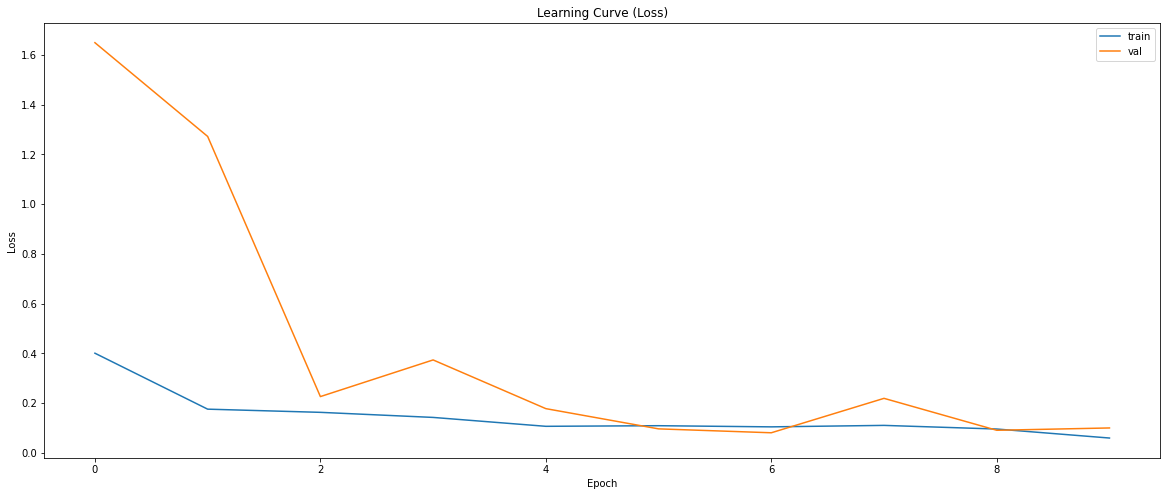

In [32]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = resnet_history.epoch, y = resnet_history.history['loss'])
sns.lineplot(x = resnet_history.epoch, y = resnet_history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['train', 'val'], loc='best')
plt.show()

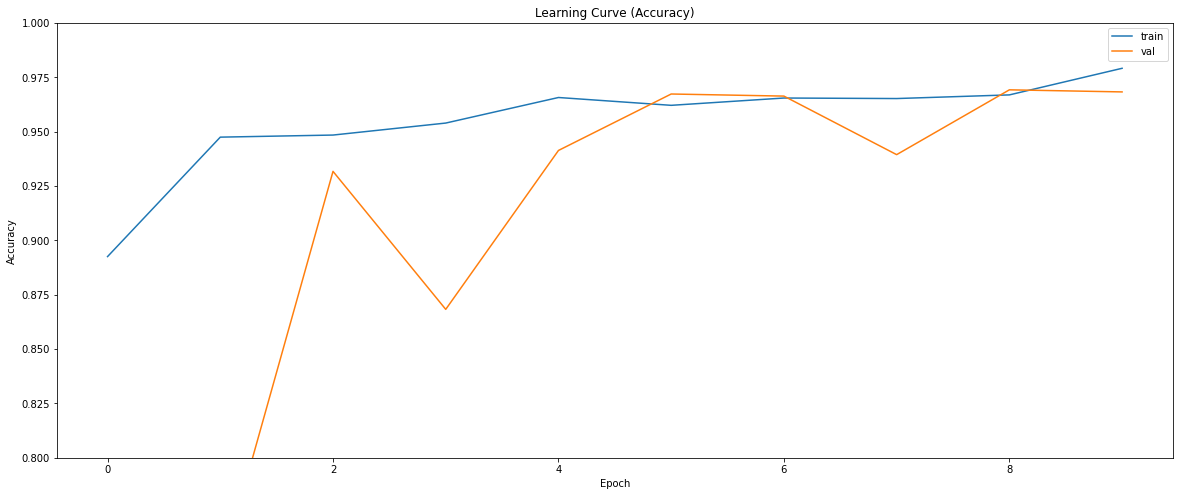

In [33]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = resnet_history.epoch, y = resnet_history.history['binary_accuracy'])
sns.lineplot(x = resnet_history.epoch, y = resnet_history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [34]:
score = resnet.evaluate(ds_val, steps = len(val_df)/BATCH_SIZE, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.09953931719064713
Val accuracy: 0.9684813618659973


회고
Data augmentation 적용 후
기본 모델
Val loss: 0.16092343628406525
Val accuracy: 0.9379178881645203

콜백추가 및 모델 구조 변경
Val loss: 0.13327740132808685
Val accuracy: 0.9455587267875671

Resnet 모델
Val loss: 0.09953931719064713
Val accuracy: 0.9684813618659973

loss 및 accuracy가 점점 발전하는 게 보입니다.

Data augmentation을 이용하여 학습 데이터를 더 다양하게 만들어 학습시키니 그 전보다 약 10%가량의 accuracy의 개선이 있었습니다.
약 93%의 accuracy를 보였지만 더 개선의 여지가 있었습니다.
기본 모델 구조에 Dropout 및 BatchNormalization을 추가하였고 early stopping, ReduceLROnPlateau 콜백 함수를 구현하여 모델의 성능을 개선하였습니다.
약 94%의 accuracy를 달성하여 약 0.8%p의 accuracy개선이 이루어졌습니다.
다음에는 아예 모델의 구조를 2015 ILSVRC 대회에서 우수한 성능을 보여준 Resnet 구조를 사용하여 학습시켰습니다.
callback과 Data augmentation 또한 적용하였습니다.
약 97%의 accuracy를 달성하였고 가장 높은 성능을 보여주었습니다.

위 과정을 진행하며 Data를 model에 input으로 넣기 위해 format하는데 어려움이 있었습니다.
Data augmentation 적용 전은 노드에서 안내하는 방식으로 data-set을 사용하였지만 기존 keras 내장 메소드인 ImageDataGenerator로 Data augmentation을 진행하기에는 data type이 일치하지 않았습니다.
ImageDataGenerator에서 Data augmentation을 진행하려면 data type에 dataframe또는 directory가 필요합니다. 하지만 directory로 진행하기에는 데이터의 imbalance 문제가 있었기 때문에 데이터의 적절한 분할이 필요했고, dataframe type으로 변환하여 작업했습니다.